In [48]:
import torch
import pickle
import gzip
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

In [49]:
file = gzip.open("mnist.pkl.gz")
((x_train, y_train), (x_valid, y_valid), _ )=pickle.load(file, encoding='latin-1')

In [50]:
x_train[0].shape

(784,)

In [51]:
28*28

784

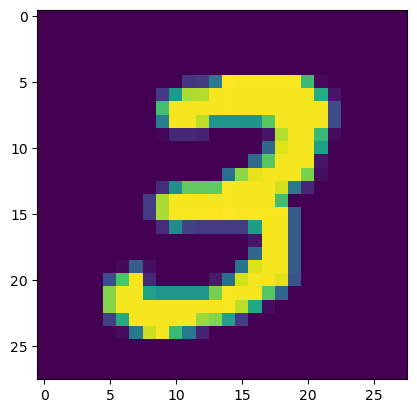

In [52]:
sample_image=x_train[7]
sample_image=sample_image.reshape((28, 28))
plt.imshow(sample_image)

In [53]:
y_train[7]

3

# Überlegungen zur Netzarchitektur

InputNeuronen: 784
OutputNeuronen: 10

    - Neuron 0 --> wenn der Wert hier am höchsten ist. Dann soll es eine 0 sein
    - Neuron 1 --> wenn der Wert hier am höchsten ist. Dann soll es eine 1 sein
    - Neuron 2 --> wenn der Wert hier am höchsten ist. Dann soll es eine 2 sein
    - Neuron 3 --> wenn der Wert hier am höchsten ist. Dann soll es eine 3 sein
    ...


In [54]:
loss = nn.CrossEntropyLoss()

In [55]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_valid, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_valid, dtype=torch.long)

In [62]:
class MySimpleNN(torch.nn.Module):   # MySimpleNN erbt von torch.nn.Module

    # Konstruktor
    def __init__(self):
        # Aufruf des Superkonstruktors von torch.nn.Module
        super(MySimpleNN, self).__init__()
        # Definition der Schichten

        # fc1 --> fully connected layer 1 von 12 auf 70 Neuronen
        # warum 12? --> 12 Features
        self.fc1 = torch.nn.Linear(784, 300)
        # fc2 --> fully connected layer 2 von 70 auf 120 Neuronen
        self.fc2 = torch.nn.Linear(300, 100)
        # fc3 --> fully connected layer 3 von 120 auf 30 Neuronen
        self.fc3 = torch.nn.Linear(100, 10)
        # fc4 --> fully connected layer 4 von 30 auf 1 Neuronen
        # Warum 1 Neuron? --> 1 Output, wir lesen da den Alkoholgehahlt aus

        # Batch Normalization
        # 70, 120, 30 sind die Anzahl der Neuronen in den Schichten
        self.bn1 = torch.nn.BatchNorm1d(300)
        self.bn2 = torch.nn.BatchNorm1d(100)

    # forward Methode -> Forward Propagation
    # wenn ich später ein Objekt von MySimpleNN erzeuge, dann kann ich
    # dieses Objekt mit einem Tensor aufrufen, dann wird die forward Methode
    # aufgerufen. z.B. model(x_train)
    def forward(self, xb):   # xb steht für eine Batch von X-Werten
        #print("xb", xb.shape)
        z2 = self.fc1(xb)  # dahinter steckt x@w1 + b1
        a2 = torch.relu(z2)    # alle negativen Werte werden auf 0 gesetzt, der Rest bleibt
        #print("a2", a2.shape)
        a2_bn = self.bn1(a2) # Normalisierung der Werte auf den Neuronen
        #print("a2_bn", a2_bn.shape)
        z3 = self.fc2(a2_bn) # dahinter steckt a2@w2 + b2
        #print("z3", z3.shape)
        a3 = torch.relu(z3)
        #print("a3", a3.shape)
        a3_bn = self.bn2(a3)
        #print("a3_bn", a3_bn.shape)
        y_hat = self.fc3(a3_bn)

        return y_hat

In [63]:
def get_batch(x, y, batch_size):
    # z.B. range(0, 10, 3) --> 0, 3, 6, 9
    # range(start, stop, step)
    for i in range(0, len(x), batch_size):
        # yield: gibt den Wert zurück, aber merkt sich den aktuellen Zustand
        yield x[i:i+batch_size], y[i:i+batch_size]

In [66]:
model = MySimpleNN()
xb, yb = next(get_batch(x_train, y_train, 64))
model(xb).shape

torch.Size([64, 10])

  0%|          | 0/100 [00:00<?, ?it/s]

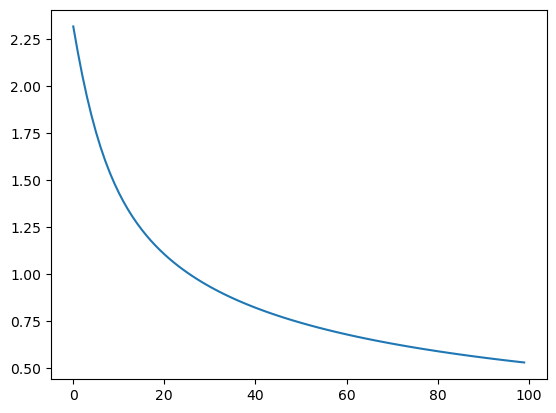

In [70]:
# eigenes Modell wird erstellt
model = MySimpleNN()
lr=0.0001
# trainiere immer mit 10 Datensätzen auf einmal
batch_size=512

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    with torch.no_grad():
        # Iteration über alle Parameter im Modell
        for param in model.parameters():
            # Backpropagation, d.h. die Veränderung der Gewichte in Abhängigkeit der Ableitung
            param -= lr * param.grad
        # Alle Gradients im Modell werden auf 0 gesetzt
        model.zero_grad()
    return loss.item()

losses=[]
batch_count=len(x_train)//batch_size
# import tqdm notebook
from tqdm.notebook import tqdm
for epoch in tqdm(range(100)):
    loss_sum=0
    # Iteration über alle Batches
    for xb, yb in get_batch(x_train, y_train, batch_size):
        loss_sum+=train(xb, yb)
    losses.append(loss_sum/batch_count)

#plot
import matplotlib.pyplot as plt
plt.plot(losses)

In [73]:
xb_test, yb_test = next(get_batch(x_test, y_test, 64))
preds = model(xb_test)
preds.shape

torch.Size([64, 10])

64: Batch-Size
10: das sind die Neuronen auf dem Outputlayer
d.h.: wir haben für jedes Bild in der Batch jeweils 10 Neuronen als Ergebnis

Was würde z.B. [ 0.1, 0.7, 0.01, 0.07, 0.04. 0.3, 0.1, 0.8, 0.0, 0.1 ] bedeuten? --> 7 wird predicted

In [74]:
preds[0]

tensor([-0.8581,  0.9471,  1.1328,  3.1430, -2.1607,  0.4141, -1.4902, -1.0822,
        -0.3741, -1.8699], grad_fn=<SelectBackward0>)

An welcher Stelle ist die höchste Zahl

In [77]:
torch.argmax(preds[0]) # argmax liefert den Index der höchsten Zahl

tensor(3)

In [78]:
yb_test[0]

tensor(3)

Das ist korrekt predictet!!

In [108]:

preds = model(x_test)
preds = torch.argmax(preds, dim=1)


In [115]:
correct=0
for i in range(len(preds)):
    if preds[i]==y_valid[i]:
        correct+=1

print(correct, "von ", len(x_valid), "korrekt vorhergesagt")

9003 von  10000 korrekt vorhergesagt


In [117]:
# kürzere Alternative
correct=sum(preds == y_test)
correct

tensor(9003)